# Unzip the data

In [3]:
!unzip 'data.zip'

Archive:  data.zip
  inflating: data/hinglish_stopwords.txt  
   creating: data/test/
  inflating: data/test/Hindi_test_unalbelled_conll_updated.txt  
  inflating: data/test/test_labels_hinglish.txt  
   creating: data/train/
  inflating: data/train/dev_3k_split_conll.txt  
  inflating: data/train/train_14k_split_conll.txt  
  inflating: data/train/train_conll.txt  
  inflating: data/train/trial_conll.txt  


In [4]:
!pip install ktrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 49.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 71.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 56.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 90.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 41.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━

# Imports

In [5]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
from matplotlib import pyplot as plt
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_score, recall_score, accuracy_score
from nltk import download
download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Defining Tweet Class

In [6]:
class Tweet:
    def __init__(self):
        self.uid = None
        self.content = ''
        self.sentiment = ''

# Definining Methods for Data Loading and Cleaning

In [7]:
def cleanTweet(tweet):
#     print(tweet.content,"\n")
#     tweet.content = re.sub(r'@ [0-9a-zA-Z]+', '', tweet.content) # remove @ mentions
    tweet.content = re.sub(r'\_', '', tweet.content) # remove underscores
    tweet.content = re.sub(r'…', '', tweet.content) # remove elipses/dots
    tweet.content = re.sub(r'\.', '', tweet.content) # remove elipses/dots
    tweet.content = re.sub(r'^RT[\s]+', '', tweet.content) # remove RT
    tweet.content = re.sub("[#@©àâ€¦¥°¤ð¹ÿœ¾¨‡†§‹²¿¸ˆ]", '', tweet.content) # remove weird symbols
    tweet.content = tweet.content.split("http")[0].split('https')[0] # remove http/https
    tweet.content = ''.join([i for i in tweet.content if not i.isdigit()]) # remove digits
    tweet.content = ''.join([word for word in tweet.content if word not in string.punctuation]) # remove punctuations
    tweet.content = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True).tokenize(tweet.content)
    tweet.content = ' '.join([i for i in tweet.content]) # convert to string
#     print(tweet.content)
#     print("============================================================================")
    return tweet

def load_stop_words():
    stopwords_english = stopwords.words('english')
    stopwords_hinglish = []
    with open('data/hinglish_stopwords.txt','r') as fp:
        while True:
            line = fp.readline()
            if not line:
                break
            stopwords_hinglish.append(line.strip())
    return stopwords_english, stopwords_hinglish

def readFile(filename, test_data=False):
    stemmer_english = PorterStemmer()
    stopwords_english, stopwords_hinglish = load_stop_words()
    all_tweets = []
    with open(filename, 'r', encoding="utf8") as fp:
        tweet = Tweet()
        last_one = False
        while True:
            line = fp.readline()
            if not line:
                last_one = True
            if len(line.split()) > 1 or last_one==True:
                if last_one==True or line.split()[0] == 'meta':
                    if len(tweet.content) > 0 or last_one==True:
                        all_tweets.append(cleanTweet(tweet))
                        if last_one==True:
                            break
                        tweet = Tweet()
                    tweet.uid = line.split()[1]
                    tweet.sentiment = line.split()[2] if test_data==False else None
                else:
                    if line.split()[1] == "Eng":
                        if line.split()[0] not in stopwords_english:
#                             line.split()[0] = autoCorrect(line.split()[0])
                            tweet.content += stemmer_english.stem(line.split()[0]) + " "
                    elif line.split()[1] == "Hin":
                        if line.split()[0] not in stopwords_hinglish:
                            tweet.content += line.split()[0] + " "
                    else:
                        tweet.content += line.split()[0] + " "
        return all_tweets

# Defining Method for Showing Results

In [8]:
def plot_confusion_matrix(cm,title='Confusion Matrix',cmap=plt.cm.Greens):
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    classes = ['neutral','positive','negative']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def show_results(y_test, y_pred):
    classification_rep = classification_report(y_test, y_pred, labels=[0, 1, 2])
    print("Classification Report:")
    print(classification_rep)

    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    support = np.sum(confusion_matrix(y_test, y_pred, labels=[0, 1, 2]), axis=1)
    accuracy = accuracy_score(y_test, y_pred)

    print("F1 Score: ", f1)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("Support: ", support)
    print("Accuracy: ", accuracy)

    cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    plot_confusion_matrix(cnf_matrix)



# ===================================================

# Mission Control - Training

### Data Loading

In [9]:
all_tweets = readFile(r'data/train/train_14k_split_conll.txt')
# all_tweets.extend(readFile(r'data\train\dev_3k_split_conll.txt'))
#all_tweets = (readFile(r'data/train/train_conll.txt'))
# all_tweets = (readFile(r'data\train\trial_conll.txt'))

### ktrain Stuff

In [10]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [11]:
import ktrain
from ktrain import text

In [12]:
x_train = [i.content for i in all_tweets]
y_train = [i.sentiment for i in all_tweets]

In [13]:
t = text.Transformer('vicgalle/xlm-roberta-large-xnli-anli')
trn = t.preprocess_train(x_train, y_train)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, batch_size=6)

preprocessing train...
language: en
train sequence lengths:
	mean : 13
	95percentile : 20
	99percentile : 24


Is Multi-Label? False


In [14]:
learner.fit_onecycle(2e-7, 1)



begin training using onecycle policy with max lr of 2e-07...
2334/2334 [==============================] - 1596s 665ms/step - loss: 1.0721 - accuracy: 0.4161


# ===================================================

# Mission Control - Prediction

### Loading Prediction Data

In [15]:
actual_labels_dict = dict()
with open(r'data/test/test_labels_hinglish.txt','r') as fp:
    line = fp.readline()
    while True:
        line = fp.readline()
        if not line:
            break
        actual_labels_dict[line.strip().split(',')[0]] = line.strip().split(',')[1]
all_test_tweets = readFile(r'data/test/Hindi_test_unalbelled_conll_updated.txt',test_data=True)
for i in all_test_tweets:
    i.sentiment = actual_labels_dict[i.uid]

### Getting the Predictions

In [16]:
predictor = ktrain.get_predictor(learner.model, preproc=t)
predictions = []
for i in all_test_tweets:
    predictions.append(predictor.predict(i.content))

### The Results

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.56      0.49      1100
           1       0.57      0.62      0.59      1000
           2       0.56      0.30      0.39       900

    accuracy                           0.50      3000
   macro avg       0.52      0.49      0.49      3000
weighted avg       0.52      0.50      0.49      3000

F1 Score:  0.4927650266987383
Precision:  0.5161756567602227
Recall:  0.5013333333333333
Support:  [1100 1000  900]
Accuracy:  0.5013333333333333


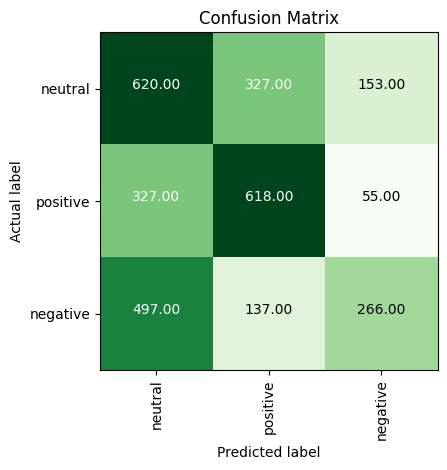

In [17]:
actual_num = []
for i in all_test_tweets:
    if i.sentiment == "neutral":
        actual_num.append(0)
    elif i.sentiment == "positive":
        actual_num.append(1)
    elif i.sentiment == "negative":
        actual_num.append(2)
predictions_num = []
for i in predictions:
    if i == "neutral":
        predictions_num.append(0)
    elif i == "positive":
        predictions_num.append(1)
    elif i == "negative":
        predictions_num.append(2)

show_results(actual_num, predictions_num)


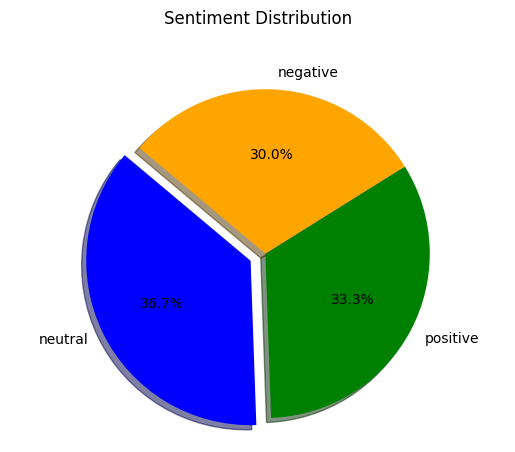

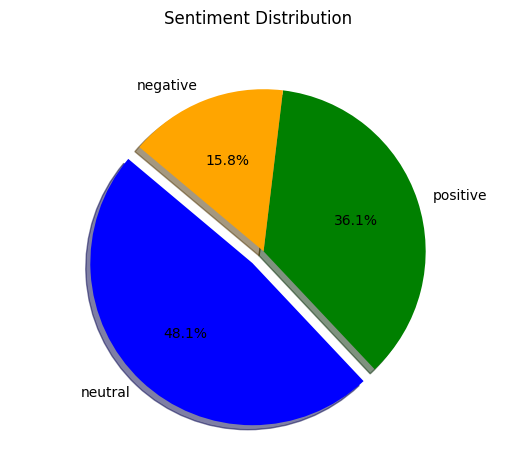

In [20]:
import matplotlib.pyplot as plt

def create_pie_chart(labels, sizes):
    colors = ['blue', 'green', 'orange']
    explode = (0.1, 0, 0)

    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')
    plt.title('Sentiment Distribution', pad=35)
    plt.show()

actual_num = []
for i in all_test_tweets:
    if i.sentiment == "neutral":
        actual_num.append("neutral")
    elif i.sentiment == "positive":
        actual_num.append("positive")
    elif i.sentiment == "negative":
        actual_num.append("negative")

predictions_num = []
for i in predictions:
    if i == "neutral":
        predictions_num.append("neutral")
    elif i == "positive":
        predictions_num.append("positive")
    elif i == "negative":
        predictions_num.append("negative")

# Create pie charts
create_pie_chart(['neutral', 'positive', 'negative'], [actual_num.count("neutral"), actual_num.count("positive"), actual_num.count("negative")])
create_pie_chart(['neutral', 'positive', 'negative'], [predictions_num.count("neutral"), predictions_num.count("positive"), predictions_num.count("negative")])


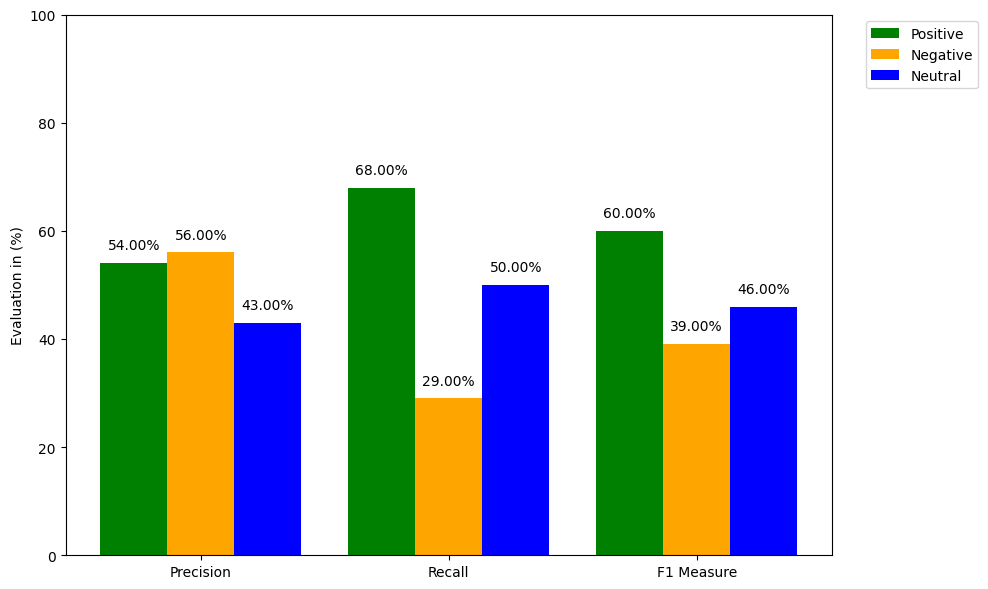

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def create_combined_bar_graph(labels, positive_scores, negative_scores, neutral_scores):
    x = np.arange(len(labels))
    width = 0.27

    plt.figure(figsize=(10, 6))

    plt.bar(x - width, positive_scores, width, label='Positive', color='green')
    plt.bar(x, negative_scores, width, label='Negative', color='orange')
    plt.bar(x + width, neutral_scores, width, label='Neutral', color='blue')

    plt.ylabel('Evaluation in (%)')
    plt.xticks(x, labels)

    # Set y-axis limit to 100
    plt.ylim(0, 100)

    # Place the legend on the outside upper right corner
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    # Add data values as labels on the bars
    for i, val in enumerate(positive_scores):
        plt.annotate(f'{val:.2f}%', (x[i] - width, val), textcoords="offset points", xytext=(0,10), ha='center')

    for i, val in enumerate(negative_scores):
        plt.annotate(f'{val:.2f}%', (x[i], val), textcoords="offset points", xytext=(0,10), ha='center')

    for i, val in enumerate(neutral_scores):
        plt.annotate(f'{val:.2f}%', (x[i] + width, val), textcoords="offset points", xytext=(0,10), ha='center')

    plt.tight_layout()
    plt.grid(False)
    plt.show()

positive_scores = [54.0, 68.0, 60.0]  # Replace with actual positive scores
negative_scores = [56.0, 29.0, 39.0]  # Replace with actual negative scores
neutral_scores = [43.0, 50.0, 46.0]   # Replace with actual neutral scores

metrics = ['Precision', 'Recall', 'F1 Measure']

# Create the combined bar graph
create_combined_bar_graph(metrics, positive_scores, negative_scores, neutral_scores)


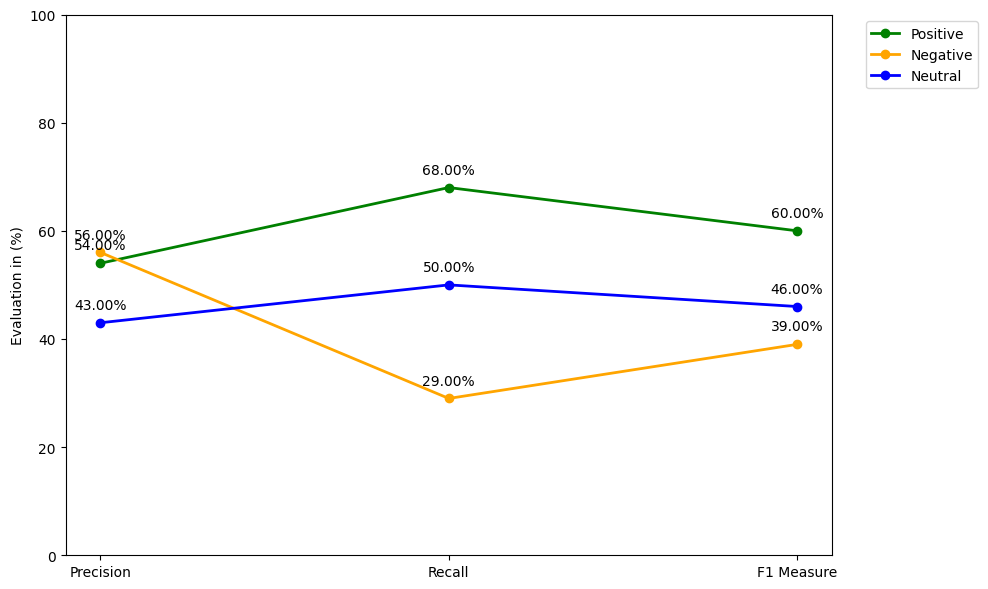

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def create_combined_line_graph(labels, positive_scores, negative_scores, neutral_scores):
    x = np.arange(len(labels))

    plt.figure(figsize=(10, 6))

    plt.plot(x, positive_scores, marker='o', label='Positive', color='green', linewidth=2)
    plt.plot(x, negative_scores, marker='o', label='Negative', color='orange', linewidth=2)
    plt.plot(x, neutral_scores, marker='o', label='Neutral', color='blue', linewidth=2)

    plt.ylabel('Evaluation in (%)')
    plt.xticks(x, labels)

    # Set y-axis limit to 100
    plt.ylim(0, 100)

    # Place the legend on the outside upper right corner
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    # Add data values as labels on the points
    for i, val in enumerate(positive_scores):
        plt.annotate(f'{val:.2f}%', (x[i], val), textcoords="offset points", xytext=(0,10), ha='center')

    for i, val in enumerate(negative_scores):
        plt.annotate(f'{val:.2f}%', (x[i], val), textcoords="offset points", xytext=(0,10), ha='center')

    for i, val in enumerate(neutral_scores):
        plt.annotate(f'{val:.2f}%', (x[i], val), textcoords="offset points", xytext=(0,10), ha='center')

    plt.tight_layout()
    plt.grid(False)
    plt.show()

positive_scores = [54.0, 68.0, 60.0]  # Replace with actual positive scores
negative_scores = [56.0, 29.0, 39.0]  # Replace with actual negative scores
neutral_scores = [43.0, 50.0, 46.0]   # Replace with actual neutral scores

metrics = ['Precision', 'Recall', 'F1 Measure']

# Create the combined line graph
create_combined_line_graph(metrics, positive_scores, negative_scores, neutral_scores)


# Analysing Incorrect Results

In [ ]:
for i in range(len(actual_num)):
    if (actual_num[i]!=predictions_num[i]):
        print("Actual:",all_test_tweets[i].sentiment)
        print("Predicted:",predictions[i][0][0][9:])
        print(all_test_tweets[i].content)
        print("=====================================================================")

Streaming output truncated to the last 5000 lines.
Actual: positive
Predicted: 
alkit patel kapilsharmak krushna kas i wish rishta se whosunilgrov k ban jaye comedy duniya aapki jaye
Actual: neutral
Predicted: 
insaaaashii pledgeagainstcorrupt thousand follow taken pledg accept bribe nd offer motiv s
Actual: negative
Predicted: 
sanjay tu duniya bada chutiya saale jamin gaddha khod samaa usme bhala insaniya
Actual: negative
Predicted: 
incindia good decis bann tv debat faltu bakwas h wha tv walo news milti h party naam kharab h
Actual: positive
Predicted: 
shayarimran inshallah kabhi na kabhi jeetoge dua moradabad galat kiya aapke
Actual: negative
Predicted: 
mediacellppp bbhuttozardari pehlay corrupt baap product order fiqar ker billo sahiba
Actual: neutral
Predicted: 
rssurjewala sir ji peopl india modi ji aap behalf bole
Actual: negative
Predicted: 
anjanaomkashyap teri bhrastachaari badi bhrastachaari maha bikau fixer
Actual: neutral
Predicted: 
rt rajesh weets haqdaar banna asaan 

In [ ]:
import csv
import pandas as pd
import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Map sentiment labels to sentiment scores
sentiment_to_score = {"positive": 1.0, "neutral": 0.0, "negative": -1.0}

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Create a list to store the data for export
export_data = []

lemmatizer = WordNetLemmatizer()

for i, tweet in enumerate(all_test_tweets):
    sentiment_label = predictions[i]
    sentiment_score = sentiment_to_score[sentiment_label]

    words = nltk.word_tokenize(tweet.content)
    pos_tags = nltk.pos_tag(words)

    pos_tags_string = " ".join([f"{word}/{tag}" for word, tag in pos_tags])
    lemma_string = " ".join([lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags])

    export_data.append({
        'uid': tweet.uid,
        'tweet': tweet.content,
        'lemmatization': lemma_string,
        'pos_tags': pos_tags_string,
        'sentiment_score': sentiment_score,
        'sentiment_label': sentiment_label
    })

# Export data to CSV
csv_file = 'output.csv'
with open(csv_file, 'w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=['uid', 'tweet', 'lemmatization', 'pos_tags', 'sentiment_score', 'sentiment_label'])
    writer.writeheader()
    writer.writerows(export_data)
print("The output file has exported")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


The output file has exported


# ===================================================